In [7]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
df = pd.read_csv('data/Default.csv')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.set_index('Unnamed: 0', inplace=True)
df.head(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   default   10000 non-null  object 
 1   student   10000 non-null  object 
 2   balance   10000 non-null  float64
 3   income    10000 non-null  float64
 4   default2  10000 non-null  int64  
 5   student2  10000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 546.9+ KB


C:\Users\vinor\AppData\Local\Temp\ipykernel_14324\1775445930.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='default', y='balance', data=df, orient='v', ax=ax2, palette=c_palette)
C:\Users\vinor\AppData\Local\Temp\ipykernel_14324\1775445930.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='default', y='income', data=df, orient='v', ax=ax3, palette=c_palette)


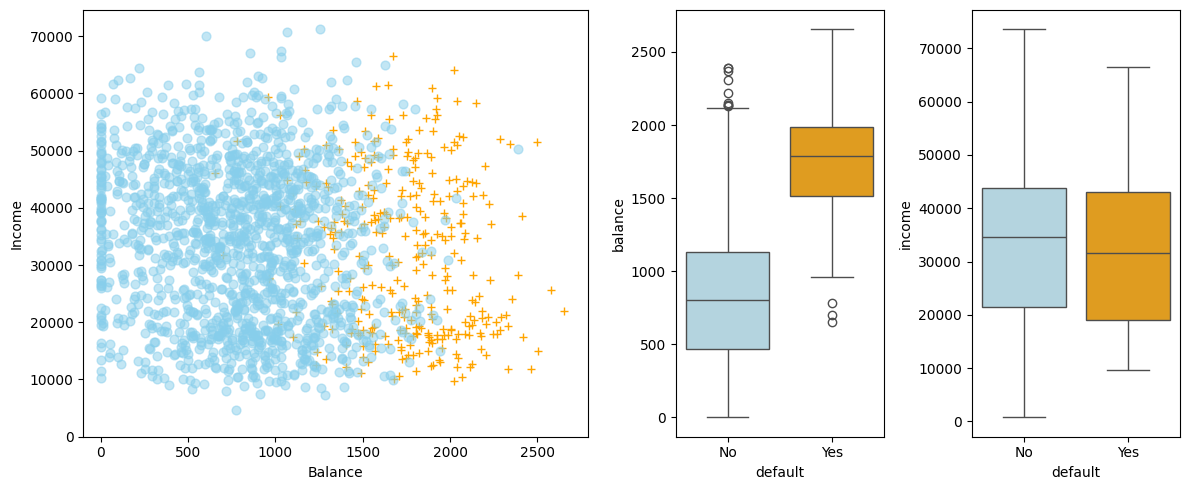

In [39]:
df.dropna(subset=['balance', 'income'], inplace=True)

fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = pd.concat([df_no, df_yes])  # Usa pd.concat anziché append

ax1.scatter(x=df_[df_.default == 'Yes'].balance, y=df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)

ax1.scatter(x=df_[df_.default == 'No'].balance, y=df_[df_.default == 'No'].income, alpha=.5, s=40, c='skyblue', marker='o',)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot(x='default', y='balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot(x='default', y='income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())